# ** PSCAN is a multi-algorithmic pipeline for easy, fast and efficient characterization of cellular sub-populations and their molecular signatures.**

The pipeline consists of four successive steps: data pre-processing, cellular clustering and pseudo-temporal ordering, determining differential expressed genes and identifying biomarkers.

![PSCAN](pscan.png)

## Required Packages

In [1]:
require(tsne)
require(pheatmap)
require(MASS)
require(cluster)
require(mclust)
require(flexmix)
require(lattice)
require(fpc)
require(amap)
require(RColorBrewer)
require(locfit)
require(TSCAN)
require(genefilter)
require(statmod)
require(ggplot2)
require(gplots)
require(DESeq2)
require(matrixStats)
require(robustbase)
require(philentropy)
require(igraph)
require(boot)
require(biomaRt)
require(tidyr)
require(calibrate)
require(partykit)
require(RWeka)
require(rpart)
require(rpart.plot)
require(imager)
require(png)
require(NetIndices) 
require(httr)
require(jsonlite)
require(tidyverse)
require(samr)
require(tidyverse)

source("RaceID_class.R")
source("PSCAN_class.R")


Loading required package: tsne
Loading required package: pheatmap
Loading required package: MASS
Loading required package: cluster
Loading required package: mclust
Package 'mclust' version 5.4.2
Type 'citation("mclust")' for citing this R package in publications.
Loading required package: flexmix
Loading required package: lattice
Loading required package: fpc
Loading required package: amap
Loading required package: RColorBrewer
Loading required package: locfit
locfit 1.5-9.1 	 2013-03-22
Loading required package: TSCAN
Loading required package: genefilter

Attaching package: 'genefilter'

The following object is masked from 'package:MASS':

    area

Loading required package: statmod
Loading required package: ggplot2
Loading required package: gplots

Attaching package: 'gplots'

The following object is masked from 'package:stats':

    lowess

Loading required package: DESeq2
Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loa

Loading required package: samr
Warning message:
"package 'samr' was built under R version 3.5.2"

## Loading datasets

The dataset should be formatted in a data frame where columns refer to samples and rows refer to genes. Usually, the last rows refer to external RNA controls consortium (ERCC) spike-ins but this pipeline can also be run without them.  

In [2]:
load("valuesG1ms.Rdata")            # Loading the full raw dataset
cat("The valuesG1ms dataset contains:","\n","Genes: ",length(valuesG1ms[,1]),"\n","cells: ",length(valuesG1ms[1,]),"\n")

load("MLSrawWithoutERCC.Rdata")    # Loading the raw dataset that does not have ERCC spike/ins
cat("The MLSrawWithoutERCC dataset contains:","\n","Genes: ",length(MLSrawWithoutERCC[,1]),"\n","cells: ",length(MLSrawWithoutERCC[1,]))

The valuesG1ms dataset contains: 
 Genes:  59838 
 cells:  94 
The MLSrawWithoutERCC dataset contains: 
 Genes:  59746 
 cells:  94

## 1. Data Pre-processing

Prior to applying data analysis methods, it is standard to pre-process the raw read counts resulted from the sequencing. The preprocessing approach depends on the existence or absence of ERCC spike-ins. In both cases, it includes normalization of read counts and gene filtering. 

#### Normalization of read counts
To account for RNA composition and sequencing depth among samples (single-cells), the normalization method “median of ratios” is used. This method takes the ratio of the gene instantaneous median to the total counts for all genes in that cell (column median). The gene instantaneous median is the product of multiplying the median of the total counts across all cells (row median) with the read of the target gene in each cell. This normalization method makes it possible to compare the normalized counts for each gene equally between samples.

#### Gene filtering
The key idea in filtering genes is to appoint the genes that manifest abundant variation across samples. Filtering genes is a critical step due to its dramatic impact on the downstream analysis. In case the raw data includes ERCC spike-ins, genes will be filtered based on variability in comparison to a noise level estimated from the ERCC spike-ins according to an algorithm developed by Brennecke et al (Brennecke et al., 2013). This algorithm utilizes the dependence of technical noise on the average read count and fits a model to the ERCC spike-ins. In case the raw data does not include ERCC spike-ins, genes will be filtered based on minimum expression in certain number of cells.


![DataPre-processing](data-pro.png)

### 1.1. Filtering and normalizing the raw data that includes ERCCs

Filtering the raw data that includes ERCCs can be done by applying the “NoiseFiltering” function, which includes 7 parameters: 
Object: the full raw dataset
percentile and CV: to determine the valid ERCC spike-ins gene_names2: gene list excluding the names of the ERCC spike-ins geneCol, FgeneCol and erccCol: color-code of the genes and ERCC spike-ins 
Val=T: to plot just the valid ERCC spike-ins 
Val=F: to plot all the ERCC spike-ins 

After generating a list of filtered genes, the function "PSCANseq" sould be implemented to create 17 slots to store the results and the parameters. The normalization method “median of ratios” can be applied by running the "Normalizedata" function. This function will discard cells with less than mintotal transcripts.


Cut-off value for the ERCCs:  12.49778 
Coefficients of the fit:  
The actual noise coefficients:  0.0200366 69.33391 
Explained variances of log CV^2 values:  0.8440294 
Number of genes that passt the filtering:  5684 
The filtered gene list was saved as: Noise_filtering_genes_test 
The filtered dataset contains: 
 Genes: 5684 
 cells: 94 
The Nois Filtered Raw dataset contains: 
 Genes: 5684 
 cells: 94

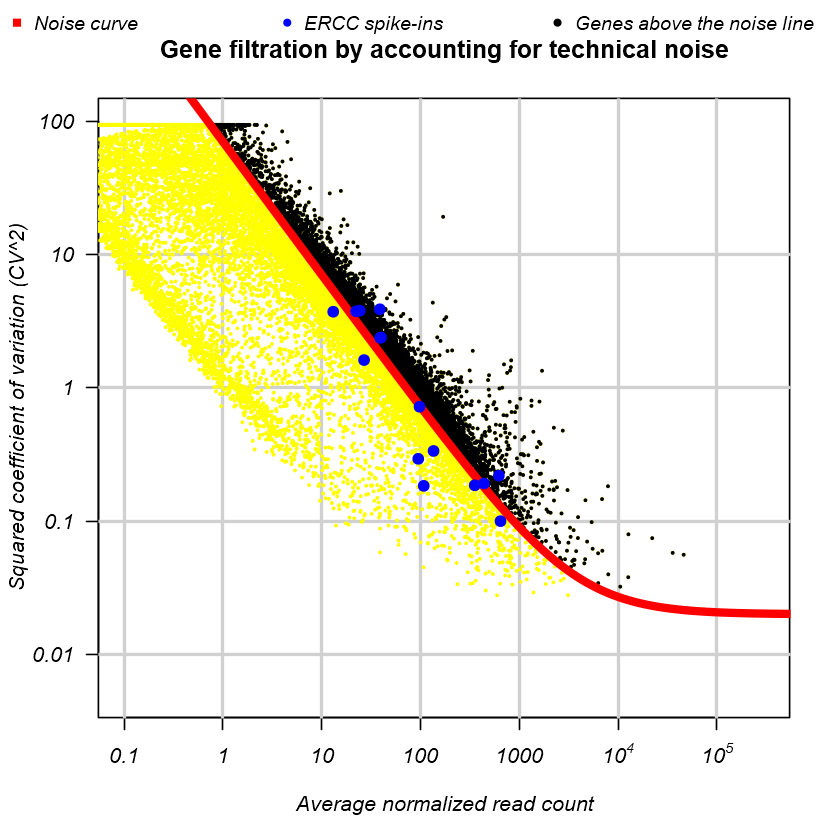

In [3]:
percentile=0.8
CV = 0.3 
Object= valuesG1ms
gene_names<-read.table("GeneNames.txt",header=F)
gene_names <- as.list(sub("*\\..*", "", unlist(gene_names)))       # Remove .x from gene ID's, since they can't be handled later on
gene_names2 <- head(gene_names,-92)

geneCol<-"yellow"
FgeneCol<-"black"
erccCol<-"blue"
noiseF<-NoiseFiltering(Object,percentile,CV,gene_names2,geneCol,FgeneCol,erccCol,Val=T)

sc<- PSCANseq(MLSrawWithoutERCC)
sc<- Normalizedata(sc,mintotal=1000)
gene_list<-noiseF
gene_names<-rownames(sc@ndata)
idx_genes <- is.element(gene_names, gene_list)
gene_names2 <- gene_names[idx_genes]
filteredDataset<- sc@ndata[gene_names2,]
cat("The filtered dataset contains:","\n","Genes:",length(filteredDataset[,1]),"\n","cells:",length(filteredDataset[1,]),"\n")
save(filteredDataset,file="filteredDataset.Rdata")
sc@fdata<-filteredDataset

############# Generating a filtered dataset with raw data for DEG analysis
gene_list<-noiseF
gene_names<-rownames(MLSrawWithoutERCC)
idx_genes <- is.element(gene_names, gene_list)
gene_names2 <- gene_names[idx_genes]
LipoNoisFilteredRawDataset<- MLSrawWithoutERCC[gene_names2,]
cat("The Nois Filtered Raw dataset contains:","\n","Genes:",length(LipoNoisFilteredRawDataset[,1]),"\n","cells:",length(LipoNoisFilteredRawDataset[1,]))
save(LipoNoisFilteredRawDataset,file="LipoNoisFilteredRawDataset.Rdata")

### 1.2. Filtering and normalizing the raw data that does not include ERCCs

####                                          {{ Do NOT run this code if you have already run 1.1  }}

The function "PSCANseq" sould be implimented to creat 17 slots to store the results and the parameters. The normalization method “median of ratios” can be applied over the raw dataset that does not include ERCCs by running the "Normalizedata" function. This function will discard cells with less than mintotal transcripts. Genes that are not expressed at minexpr transcripts in at least minnumber cells are discarded. 

In [3]:
sc<- PSCANseq(MLSrawWithoutERCC)
MIínExp<- mean(rowMeans(MLSrawWithoutERCC,na.rm=TRUE))
MinNumber<- round(length(MLSrawWithoutERCC[1,])/3)    # To be expressed in at least one third of the cells.
sc<- Normalizedata(sc, mintotal=1000, minexpr=MIínExp, minnumber=MinNumber, maxexpr=Inf, downsample=FALSE, dsn=1, rseed=17000)
cat("Number of genes that passt the filtering: ",dim(sc@fdata)[1],"\n")
filteredGenes<-rownames(sc@fdata)
write.csv(filteredGenes, file = "Expression_filtering_genes.csv")

gene_list<-filteredGenes
gene_names<-rownames(MLSrawWithoutERCC)
idx_genes <- is.element(gene_names, gene_list)
gene_names2 <- gene_names[idx_genes]
LipoExpFilteredrawdata<- MLSrawWithoutERCC[gene_names2,]
save(LipoExpFilteredrawdata,file="LipoExpFilteredrawdata.Rdata")
cat("The Filtered Raw dataset contains:","\n","Genes:",length(LipoExpFilteredrawdata[,1]),"\n","cells:",length(LipoExpFilteredrawdata[1,]))


Number of genes that passt the filtering:  6596 
The Filtered Raw dataset contains: 
 Genes: 6596 
 cells: 94

## 2. Cellular Clustering and Pseudo Time ordering

Cellular clustering is performed according to the gene expression profiles to detect cellular sub-population with unique properties. After clustering, pseudo-temporal ordering is generated to indicate the cellular differentiation degree. 

![PSCAN](Cell_clustering.png)

### 2.1. K-means Clustering

Rare cell type Identification algorithm (RaceID) was used to cluster the pre-processed data using k-means on a similarity distance matrix, which was based on Pearson correlation and the similarity matrix was computed as “1 – Pearson correlation”. The approach of the proposed clustering, i.e., applying k-means on a similarity distance matrix using the Euclidean metric, improves cluster separation. RaceID estimates the number of clusters by finding the minimal clusters' number at the saturation level of gap statistics, which standardizes the within-cluster dispersion. 

boot 1 
boot 2 
boot 3 
boot 4 
boot 5 
boot 6 
boot 7 
boot 8 
boot 9 
boot 10 
boot 11 
boot 12 
boot 13 
boot 14 
boot 15 
boot 16 
boot 17 
boot 18 
boot 19 
boot 20 
boot 21 
boot 22 
boot 23 
boot 24 
boot 25 
boot 26 
boot 27 
boot 28 
boot 29 
boot 30 
boot 31 
boot 32 
boot 33 
boot 34 
boot 35 
boot 36 
boot 37 
boot 38 
boot 39 
boot 40 
boot 41 
boot 42 
boot 43 
boot 44 
boot 45 
boot 46 
boot 47 
boot 48 
boot 49 
boot 50 


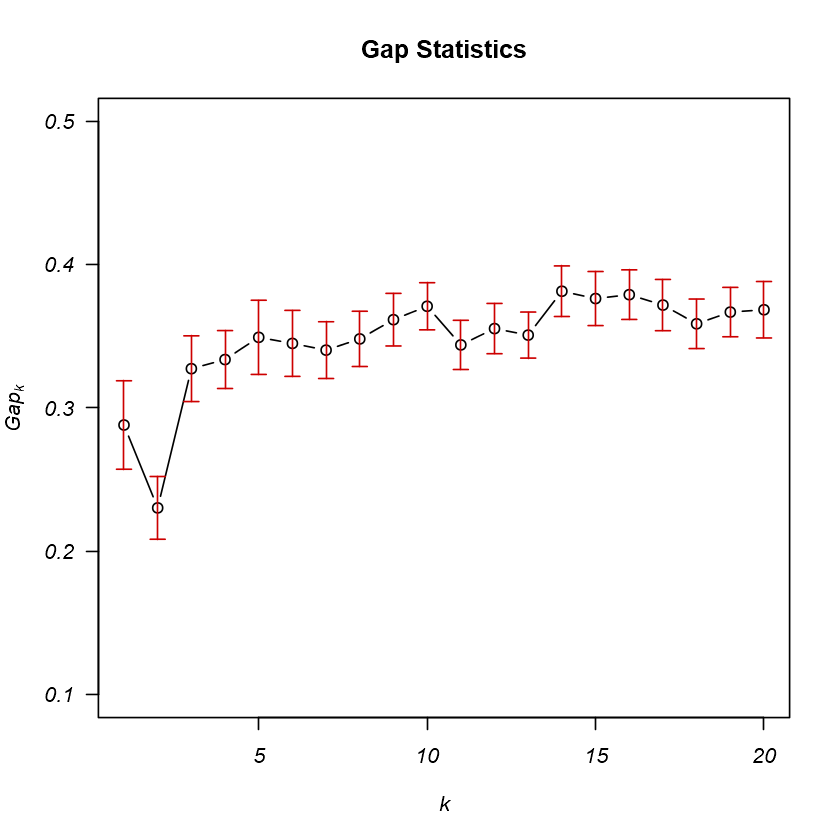

In [4]:
K=3  # Number of Clusters
sc<- Clustexp(sc, clustnr=20,bootnr=50,metric="pearson",do.gap=T,SE.method="Tibs2001SEmax",SE.factor=.25,B.gap=50,cln=K,rseed=17000)
plotGap(sc)

#### 2.1.1. Defining the Cells in the clusters generated by k-means clustering

In [5]:
sc<- comptSNE(sc,rseed=15555)
Clusters<-sc@kmeans$kpart
KmeansClusters<-Clusters   # To be used for defining DEGs
save(KmeansClusters,file="KmeansClusters.Rdata")
AllClusters<-sc@cpart   
sc@cpart <- Clusters    
cat("\t","     Cell-ID"," Cluster Number","\n")
Clusters

sigma summary: Min. : 0.140828484033208 |1st Qu. : 0.174199368111191 |Median : 0.191732234667552 |Mean : 0.199444692434548 |3rd Qu. : 0.215217261451393 |Max. : 0.347831223915885 |
Epoch: Iteration #100 error is: 15.5663516425601
Epoch: Iteration #200 error is: 1.35105698980946
Epoch: Iteration #300 error is: 0.627191906732435
Epoch: Iteration #400 error is: 0.376540986332787
Epoch: Iteration #500 error is: 0.308324230968546
Epoch: Iteration #600 error is: 0.297524678123455
Epoch: Iteration #700 error is: 0.283330956202379
Epoch: Iteration #800 error is: 0.278372106512403
Epoch: Iteration #900 error is: 0.27373483001867
Epoch: Iteration #1000 error is: 0.272834051943043


	      Cell-ID  Cluster Number 


G1_1  G1_2  G1_3  G1_4  G1_5  G1_6  G1_7  G1_8  G1_9 G1_10 G1_11 G1_12 G1_13 
    1     2     2     1     1     1     2     2     3     3     3     1     3 
G1_14 G1_15 G1_16 G1_17 G1_18 G1_19 G1_20 G1_21 G1_22 G1_23 G1_24 G1_25 G1_26 
    1     1     1     3     2     2     2     3     1     2     2     1     2 
G1_27 G1_28 G1_29 G1_30   S_1   S_2   S_3   S_4   S_5   S_6   S_7   S_8   S_9 
    3     2     2     2     2     2     2     2     2     2     2     1     2 
 S_10  S_11  S_12  S_13  S_14  S_15  S_16  S_17  S_18  S_19  S_20  S_21  S_22 
    2     2     2     2     1     2     1     2     1     1     2     2     2 
 S_23  S_24  S_25  S_26  S_27  S_28  S_29  S_30  S_31  S_32  G2_1  G2_2  G2_3 
    1     1     2     2     2     3     2     2     2     3     2     2     2 
 G2_4  G2_5  G2_6  G2_7  G2_8  G2_9 G2_10 G2_11 G2_12 G2_13 G2_14 G2_15 G2_16 
    3     1     1     2     2     2     1     3     2     1     2     3     1 
G2_17 G2_18 G2_19 G2_20 G2_21 G2_22 G2_23 G2_24 G2_25 G2_26 G2_27 G2_28 G2_29 
    1     1     2     2     2     1     3     1     2     3     3     2     2 
G2_30 G2_31 G2_32 
    1     2     2

#### 2.1.2- Evaluating the stability and consistancy of the clusters

PSCAN enables the robustness assessment of the detected clusters in terms of stability and consistency using Jaccard’s similarity statistics and silhouette coefficients. Jaccard’s similarity index provides a comparison of members among clusters to evaluate the stability of the clusters with a range from 0% to 100%. The higher the percentage, the more stable the cluster is. Silhouette coefficients estimate how close each sample in one cluster is to samples in the neighboring clusters, reflecting the consistency of each cluster with a range of [-1, 1]. The higher the cluster mean coefficient, the more consistent the cluster is.

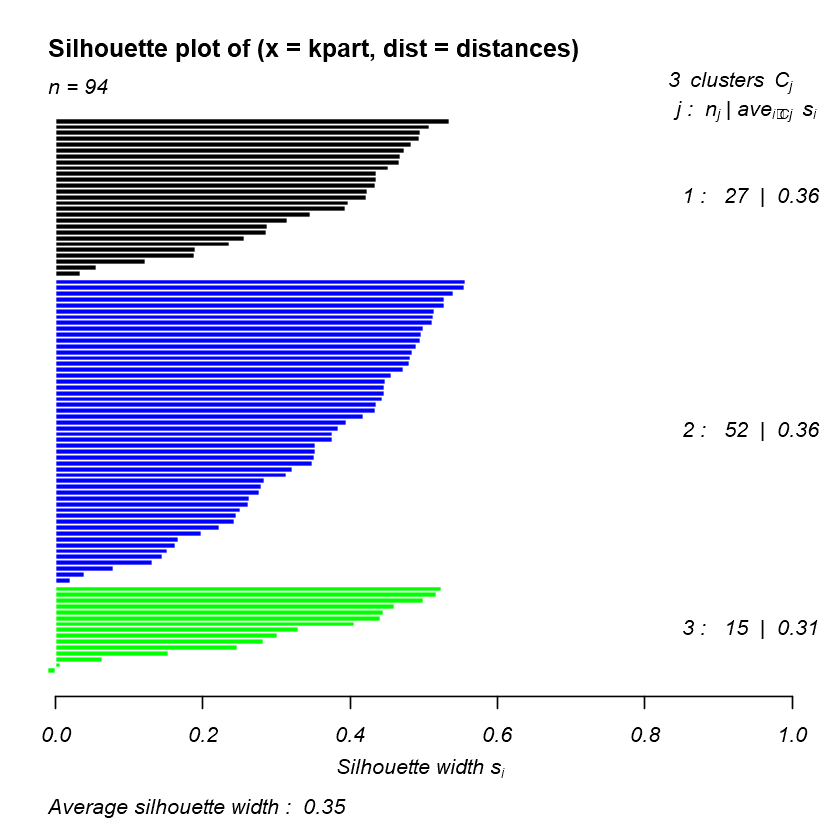

In [6]:
# Silhouette of k-means clusters
par(mar=c(6,2,4,2))
plotSilhouette(sc)   

Metric: 'jaccard' using unit: 'log'.
Metric: 'jaccard' using unit: 'log'.
Metric: 'jaccard' using unit: 'log'.
Metric: 'jaccard' using unit: 'log'.
Metric: 'jaccard' using unit: 'log'.
Metric: 'jaccard' using unit: 'log'.
Metric: 'jaccard' using unit: 'log'.
Metric: 'jaccard' using unit: 'log'.
Metric: 'jaccard' using unit: 'log'.
Metric: 'jaccard' using unit: 'log'.
Metric: 'jaccard' using unit: 'log'.
Metric: 'jaccard' using unit: 'log'.
Metric: 'jaccard' using unit: 'log'.
Metric: 'jaccard' using unit: 'log'.
Metric: 'jaccard' using unit: 'log'.
Metric: 'jaccard' using unit: 'log'.
Metric: 'jaccard' using unit: 'log'.
Metric: 'jaccard' using unit: 'log'.
Metric: 'jaccard' using unit: 'log'.
Metric: 'jaccard' using unit: 'log'.
Metric: 'jaccard' using unit: 'log'.
Metric: 'jaccard' using unit: 'log'.
Metric: 'jaccard' using unit: 'log'.
Metric: 'jaccard' using unit: 'log'.
Metric: 'jaccard' using unit: 'log'.
Metric: 'jaccard' using unit: 'log'.
Metric: 'jaccard' using unit: 'log'.
M

Metric: 'jaccard' using unit: 'log'.
Metric: 'jaccard' using unit: 'log'.
Metric: 'jaccard' using unit: 'log'.
Metric: 'jaccard' using unit: 'log'.
Metric: 'jaccard' using unit: 'log'.
Metric: 'jaccard' using unit: 'log'.
Metric: 'jaccard' using unit: 'log'.
Metric: 'jaccard' using unit: 'log'.
Metric: 'jaccard' using unit: 'log'.
Metric: 'jaccard' using unit: 'log'.
Metric: 'jaccard' using unit: 'log'.
Metric: 'jaccard' using unit: 'log'.
Metric: 'jaccard' using unit: 'log'.
Metric: 'jaccard' using unit: 'log'.
Metric: 'jaccard' using unit: 'log'.
Metric: 'jaccard' using unit: 'log'.
Metric: 'jaccard' using unit: 'log'.
Metric: 'jaccard' using unit: 'log'.
Metric: 'jaccard' using unit: 'log'.
Metric: 'jaccard' using unit: 'log'.
Metric: 'jaccard' using unit: 'log'.
Metric: 'jaccard' using unit: 'log'.
Metric: 'jaccard' using unit: 'log'.
Metric: 'jaccard' using unit: 'log'.
Metric: 'jaccard' using unit: 'log'.
Metric: 'jaccard' using unit: 'log'.
Metric: 'jaccard' using unit: 'log'.
M

[1] 0.671 0.768 0.681

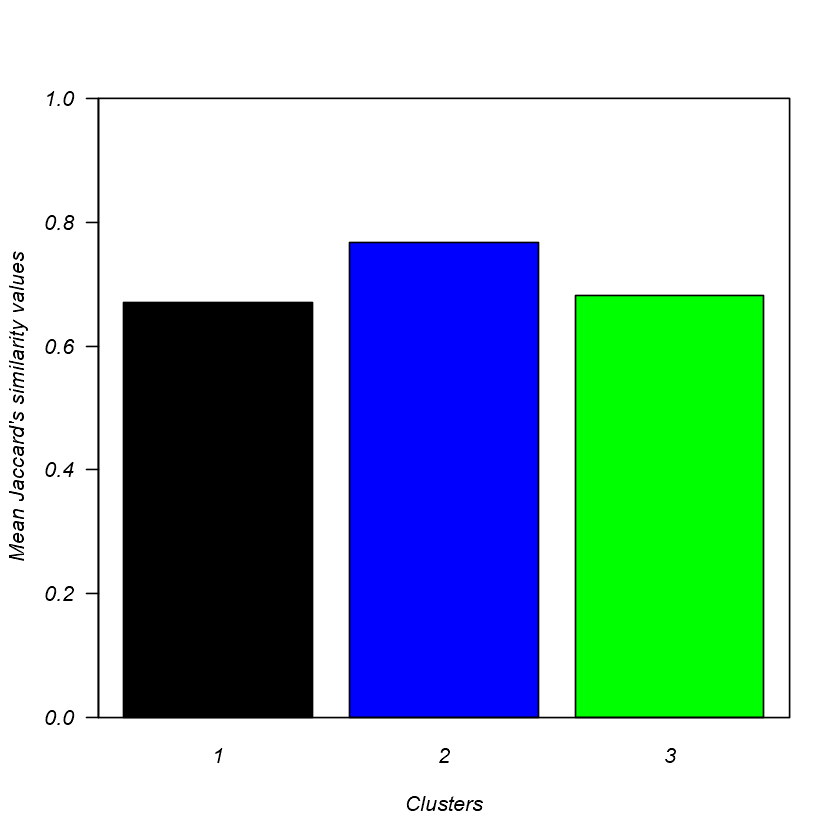

In [7]:
Clustering="K-means" # Jaccard of k-means clusters
#Clustering="MB"       # Jaccard of Model based clusters
Jaccard(sc,Clustering)

#### 2.1.3. Cluster plotting using tSNE maps

Here you visualize the K-means clusters using t-distributed stochastic neighbor embedding (tSNE), which is a non-linear dimensionality reduction method that places neighbor cells close to each other. 

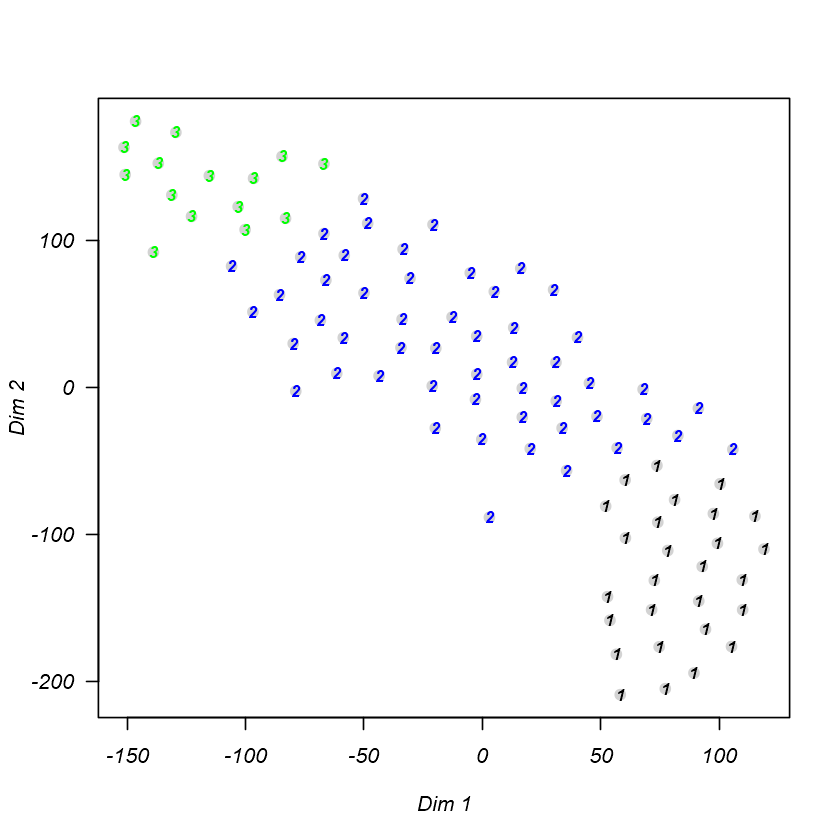

In [8]:
plottSNE(sc)

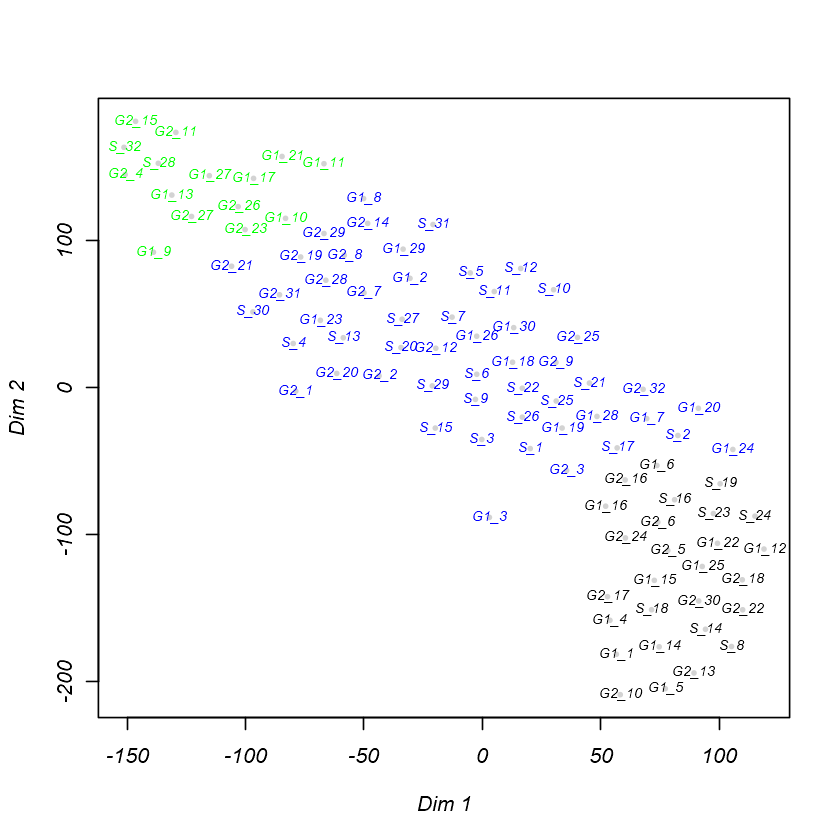

In [9]:
plotKmeansLabelstSNE(sc) # To plot the the ID of the cells in eacj cluster

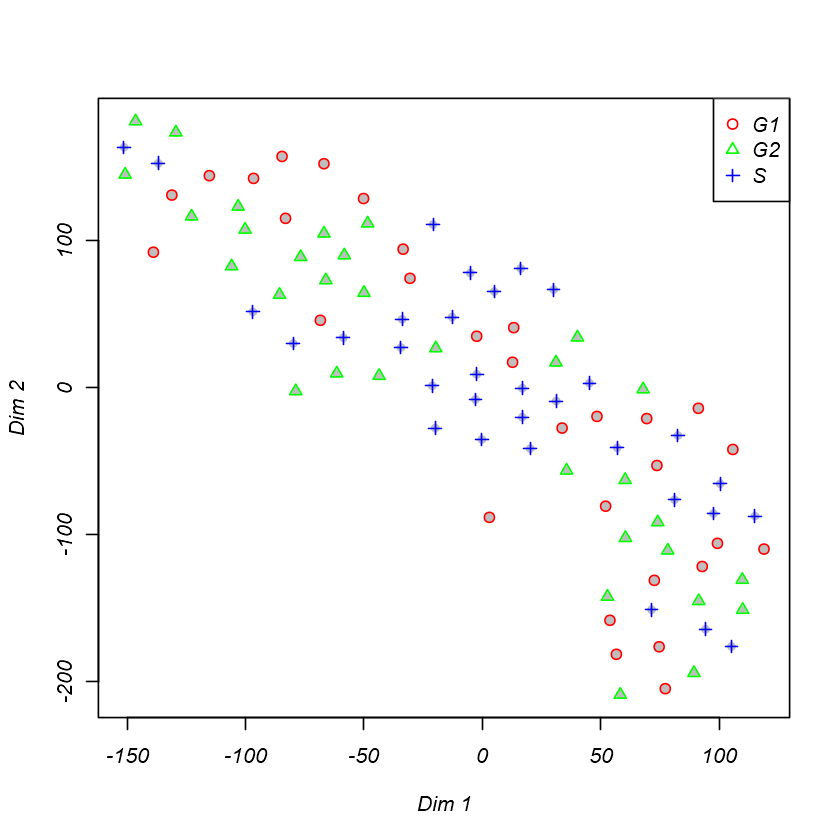

In [10]:
plotSymbolstSNE(sc,types=sub("(\\_\\d+)$","", names(sc@ndata)))    
# To plot the cells colored according to their group based on cell-cycle phases.

### Defining outlier cells based on K-means Clustering

The following cells are considered as outlier cells: 1 13 22 
 G1_1 G1_13 G1_22 
    1    13    22 


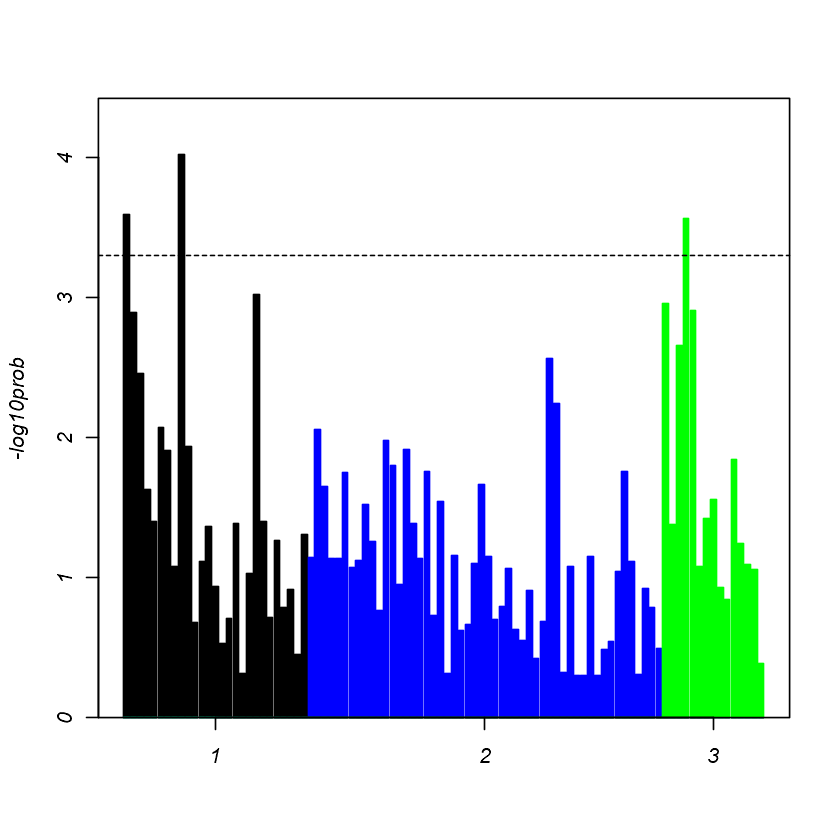

In [11]:
outlg<-round(length(sc@fdata[,1])/200)     # The cell will be considered as an outlier if it has a minimum of 0.5% of the number of filtered genes as outlier genes. 
Outliers<- FindOutliersKM(sc, outminc=5,outlg=outlg,probthr=.5*1e-3,thr=2**-(1:40),outdistquant=1)
                      

#### Removing the defined outlier cells based on K-means Clustering

In case the user decided to remove outlier cells, the following cell should be implemented and then the user should start from the beginning (Data Pre-processing). 

In [ ]:
########## Do NOT implement this code if you decided not to remove the outlier cells
names(scc)=NULL
scc
valuesG1ms=valuesG1ms[-scc]
MLSrawWithoutERCC=MLSrawWithoutERCC[-scc]

dim(valuesG1ms)
dim(MLSrawWithoutERCC)

colnames(valuesG1ms)
colnames(MLSrawWithoutERCC)

#### 2.1.4. Cellular pseudo-time ordering based on k-means clusters 

   order orderID
1      1    S_14
2      2     S_8
3      3   G2_30
4      4   G2_22
5      5   G1_14
6      6   G2_18
7      7   G2_24
8      8    S_16
9      9    G2_5
10    10   G1_25
11    11    S_18
12    12   G1_15
13    13    G1_4
14    14    G2_6
15    15    G1_5
16    16   G1_22
17    17    S_24
18    18   G1_12
19    19   G2_13
20    20   G2_17
21    21    S_19
22    22    S_23
23    23   G1_16
24    24    G1_1
25    25   G2_16
26    26    G1_6
27    27   G2_10
28    28    G2_3
29    29    S_17
30    30    S_25
31    31     S_1
32    32   G1_19
33    33   G2_32
34    34   G1_28
35    35    S_26
36    36    G2_1
37    37   G2_25
38    38    S_22
39    39     S_3
40    40   G1_24
41    41    S_15
42    42     S_2
43    43   G1_18
44    44    S_21
45    45   G1_20
46    46    G2_9
47    47    G1_7
48    48     S_9
49    49    G1_3
50    50    G2_2
51    51     S_6
52    52    S_29
53    53     S_4
54    54     S_5
55    55    S_11
56    56   G2_20
57    57    S_10
58    58   G1_

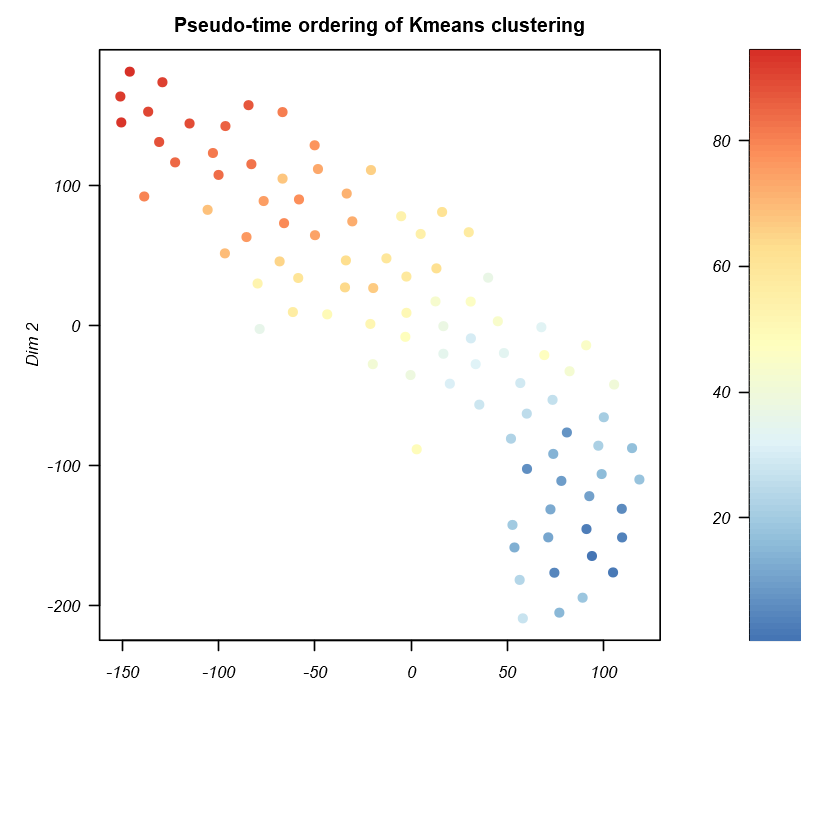

In [12]:
sampleNames<-colnames(sc@fdata)
Order<-KmeanOrder(sc@fdata,Clusters,sampleNames)
sc@kordering<-Order
sc@ndata<-rbind(sc@ndata,sc@kordering)
rownames(sc@ndata)[nrow(sc@ndata)]<-"Pseudo-time ordering of Kmeans clustering"  # in case the user wanted to repeat this step the name: "Pseudo-time ordering of Kmeans clustering" should be change each time.
g<-rownames(sc@ndata)[nrow(sc@ndata)]
plotExptSNE(sc,g)

#### 2.1.5 Plotting the K-means clusters in heatmap

The similarities between single-cells were computed by Euclidean distances of Pearson transcriptome correlation matrix. Based on these similarities, a heatmap portrayal of cell-to-cell distances was plotted using Euclidean as the distance measure and the single linkage as the clustering method, cluster centers were ordered by hierarchic clustering. 

[1] 3 1 2

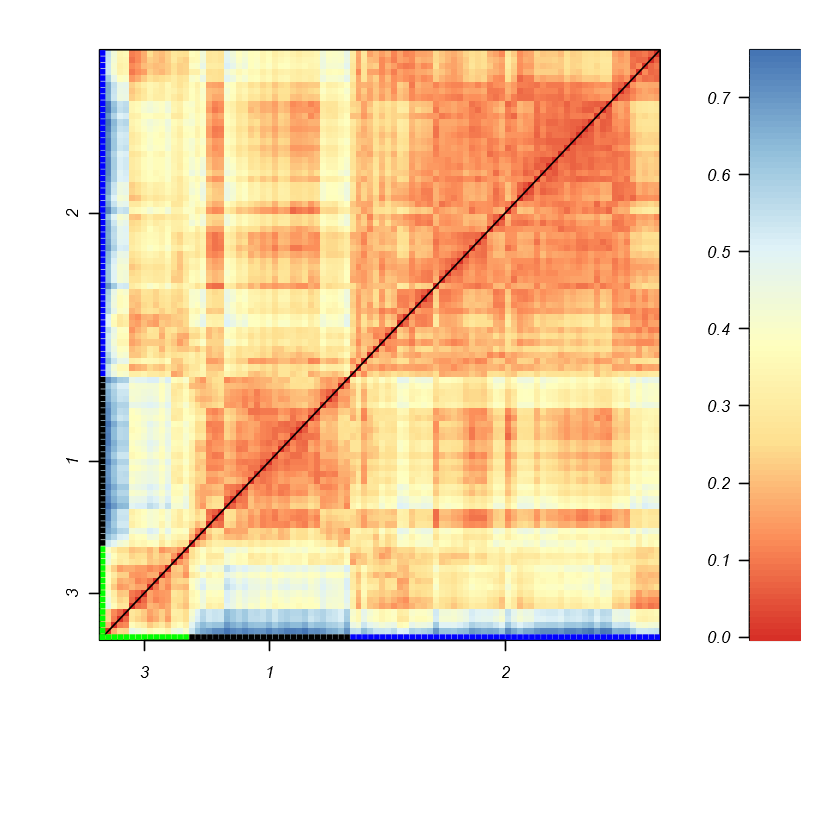

In [13]:
KMclustheatmap(sc)    # Plotting the K-means clusters in heatmap

### 2.2. Model-Based clustering

Model-based clustering assumes that the data are generated by a model and attempts to recover the original model from the data to define cellular clusters.

#### 2.2.1. Defining the Cells in the clusters generated by model-based clustering

In [14]:
K=3
procdataTSCAN<-sc@fdata
lpsmclustMB <- exprmclust(procdataTSCAN,clusternum =K,reduce = T)
MBClusters<-lpsmclustMB$clusterid   # To be used for defining DEGs
sc@MBclusters<-MBClusters
cat("\t","     Cell-ID"," Cluster Number","\n")
MBClusters
save(MBClusters,file="MBClusters.Rdata")

	      Cell-ID  Cluster Number 


G1_1  G1_2  G1_3  G1_4  G1_5  G1_6  G1_7  G1_8  G1_9 G1_10 G1_11 G1_12 G1_13 
    1     1     1     1     1     1     1     1     1     1     1     1     1 
G1_14 G1_15 G1_16 G1_17 G1_18 G1_19 G1_20 G1_21 G1_22 G1_23 G1_24 G1_25 G1_26 
    1     1     1     1     1     1     3     1     1     1     1     1     2 
G1_27 G1_28 G1_29 G1_30   S_1   S_2   S_3   S_4   S_5   S_6   S_7   S_8   S_9 
    1     3     1     1     3     1     3     3     3     3     1     1     3 
 S_10  S_11  S_12  S_13  S_14  S_15  S_16  S_17  S_18  S_19  S_20  S_21  S_22 
    1     3     3     3     3     1     1     3     1     3     3     3     3 
 S_23  S_24  S_25  S_26  S_27  S_28  S_29  S_30  S_31  S_32  G2_1  G2_2  G2_3 
    3     1     3     3     3     3     3     3     1     3     1     2     1 
 G2_4  G2_5  G2_6  G2_7  G2_8  G2_9 G2_10 G2_11 G2_12 G2_13 G2_14 G2_15 G2_16 
    3     2     2     2     2     1     3     1     3     1     2     2     1 
G2_17 G2_18 G2_19 G2_20 G2_21 G2_22 G2_23 G2_24 G2_25 G2_26 G2_27 G2_28 G2_29 
    1     2     2     2     2     1     2     2     1     2     3     2     2 
G2_30 G2_31 G2_32 
    1     1     1

#### 2.2.2. Cluster plotting using PCA and tSNE maps

To visualize the detected clusters, two common dimensionality reduction tools are implemented: tSNE map and principal component analysis (PCA), which is a linear dimensionality reduction method that preserves the global structure and shows how the measurements themselves are related to each other.  

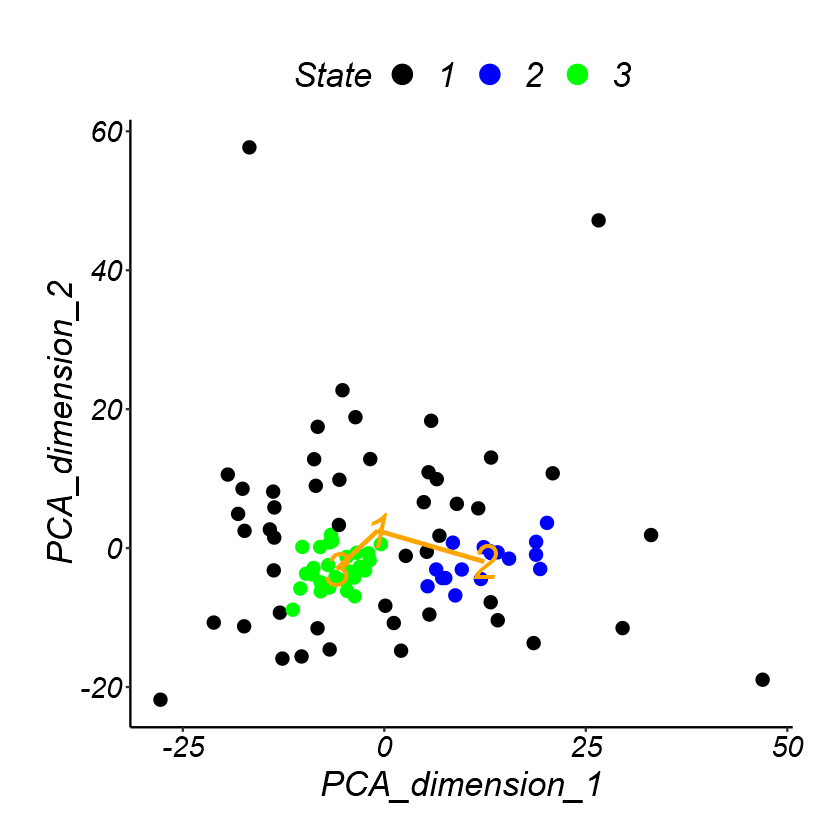

In [15]:
Plotmclust (lpsmclustMB)

This function takes time

sigma summary: Min. : 38.4914978648748 |1st Qu. : 42.9672869120877 |Median : 45.7336241172451 |Mean : 47.2423249643292 |3rd Qu. : 50.7105126779753 |Max. : 73.7307741725683 |
Epoch: Iteration #500 error is: 0.595309675598738
Epoch: Iteration #1000 error is: 0.534299981348897
Epoch: Iteration #1500 error is: 0.519911534603783
Epoch: Iteration #2000 error is: 0.519794460404417
Epoch: Iteration #2500 error is: 0.515884357093217
Epoch: Iteration #3000 error is: 0.510852489057808
Epoch: Iteration #3500 error is: 0.510110926621911
Epoch: Iteration #4000 error is: 0.503933615768461
Epoch: Iteration #4500 error is: 0.532622367838373
Epoch: Iteration #5000 error is: 0.415001973960987


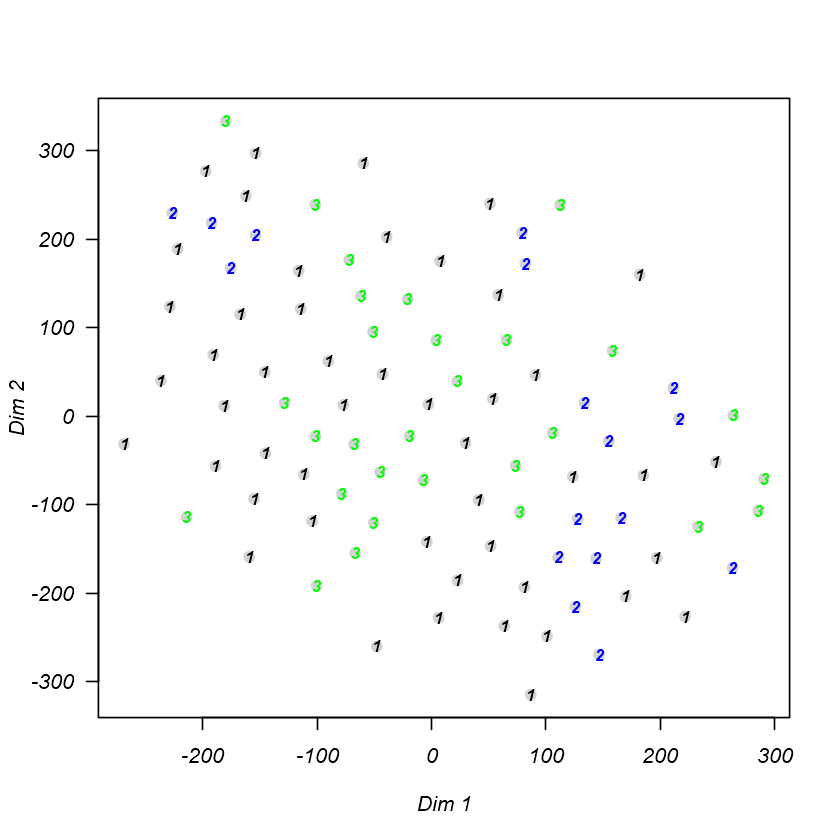

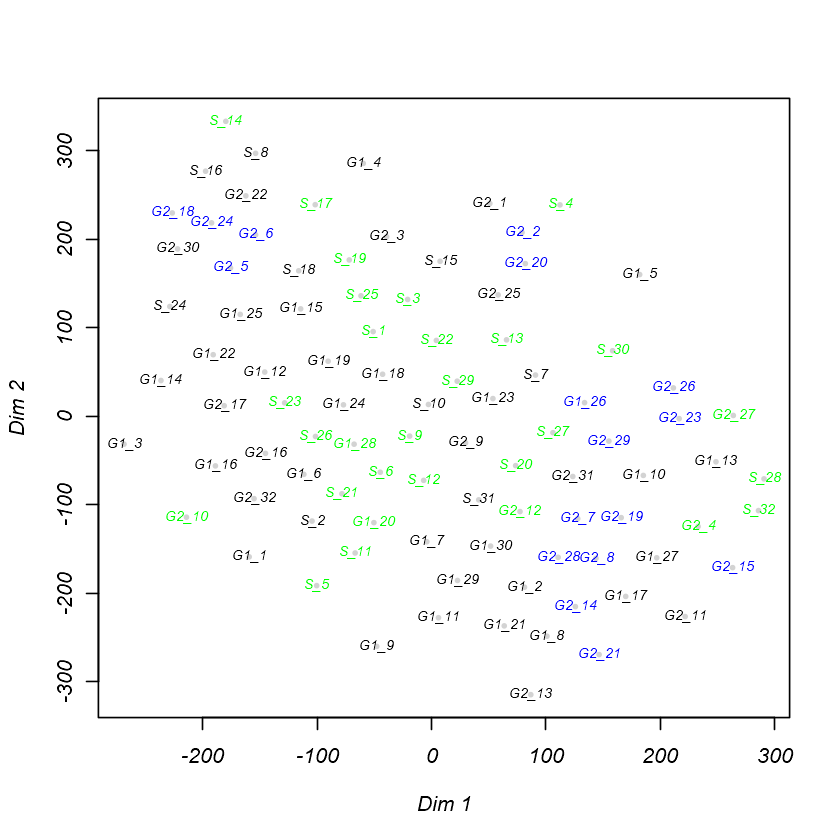

In [16]:
# Plotting the model-based clusters in tSNE maps
sc@MBclusters<-lpsmclustMB
sc<- comptsneMB(sc,rseed=15555)
plottsneMB(sc)
plotMBLabelstSNE(sc)

#### 2.2.3. Evaluating the stability and consistancy of the clusters

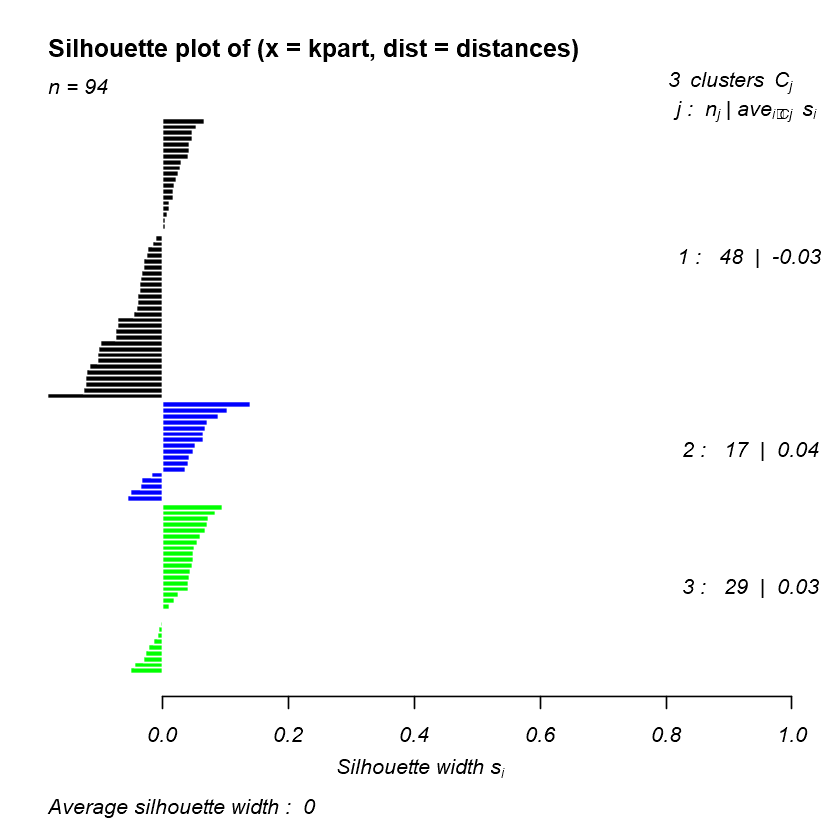

In [17]:
# Silhouette of Model-based clusters
par(mar=c(6,2,4,2))
sc@MBclusters<-lpsmclustMB
plotsilhouetteMB(sc)

Metric: 'jaccard' using unit: 'log'.
Metric: 'jaccard' using unit: 'log'.
Metric: 'jaccard' using unit: 'log'.
Metric: 'jaccard' using unit: 'log'.
Metric: 'jaccard' using unit: 'log'.
Metric: 'jaccard' using unit: 'log'.
Metric: 'jaccard' using unit: 'log'.
Metric: 'jaccard' using unit: 'log'.
Metric: 'jaccard' using unit: 'log'.
Metric: 'jaccard' using unit: 'log'.
Metric: 'jaccard' using unit: 'log'.
Metric: 'jaccard' using unit: 'log'.
Metric: 'jaccard' using unit: 'log'.
Metric: 'jaccard' using unit: 'log'.
Metric: 'jaccard' using unit: 'log'.
Metric: 'jaccard' using unit: 'log'.
Metric: 'jaccard' using unit: 'log'.
Metric: 'jaccard' using unit: 'log'.
Metric: 'jaccard' using unit: 'log'.
Metric: 'jaccard' using unit: 'log'.
Metric: 'jaccard' using unit: 'log'.
Metric: 'jaccard' using unit: 'log'.
Metric: 'jaccard' using unit: 'log'.
Metric: 'jaccard' using unit: 'log'.
Metric: 'jaccard' using unit: 'log'.
Metric: 'jaccard' using unit: 'log'.
Metric: 'jaccard' using unit: 'log'.
M

Metric: 'jaccard' using unit: 'log'.
Metric: 'jaccard' using unit: 'log'.
Metric: 'jaccard' using unit: 'log'.
Metric: 'jaccard' using unit: 'log'.
Metric: 'jaccard' using unit: 'log'.
Metric: 'jaccard' using unit: 'log'.
Metric: 'jaccard' using unit: 'log'.
Metric: 'jaccard' using unit: 'log'.
Metric: 'jaccard' using unit: 'log'.
Metric: 'jaccard' using unit: 'log'.
Metric: 'jaccard' using unit: 'log'.
Metric: 'jaccard' using unit: 'log'.
Metric: 'jaccard' using unit: 'log'.
Metric: 'jaccard' using unit: 'log'.
Metric: 'jaccard' using unit: 'log'.
Metric: 'jaccard' using unit: 'log'.
Metric: 'jaccard' using unit: 'log'.
Metric: 'jaccard' using unit: 'log'.
Metric: 'jaccard' using unit: 'log'.
Metric: 'jaccard' using unit: 'log'.
Metric: 'jaccard' using unit: 'log'.
Metric: 'jaccard' using unit: 'log'.
Metric: 'jaccard' using unit: 'log'.
Metric: 'jaccard' using unit: 'log'.
Metric: 'jaccard' using unit: 'log'.
Metric: 'jaccard' using unit: 'log'.
Metric: 'jaccard' using unit: 'log'.
M

[1] 0.660 0.766 0.812

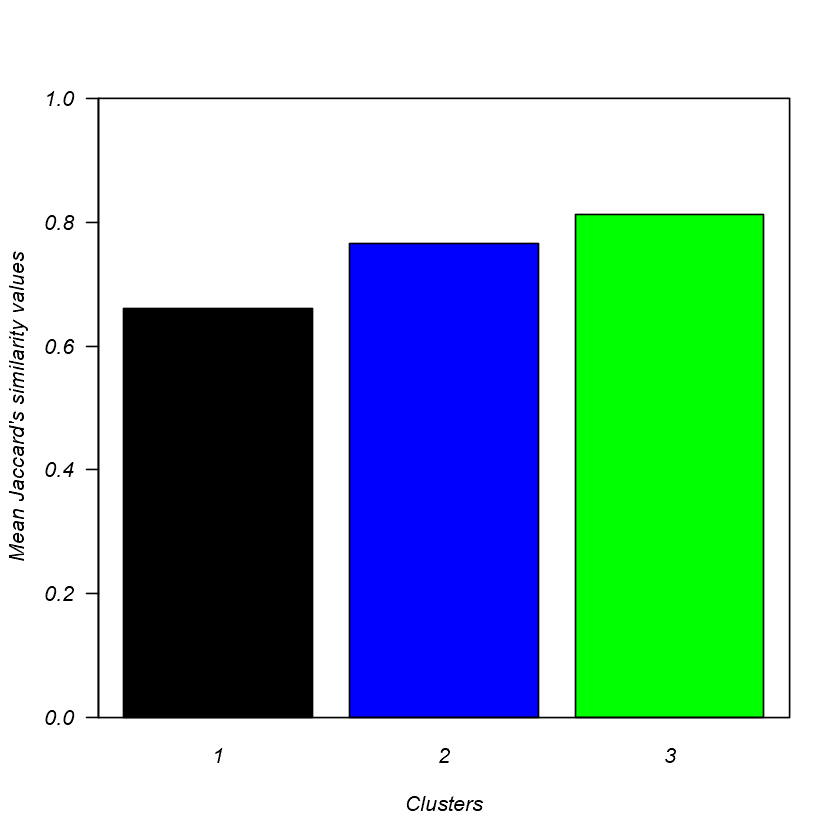

In [18]:
Clustering="MB"       # Jaccard of Model based clusters
Jaccard(sc,Clustering)

### Defining outlier cells based on Model-Based Clustering

The following cells are considered as outlier cells:  
named integer(0)


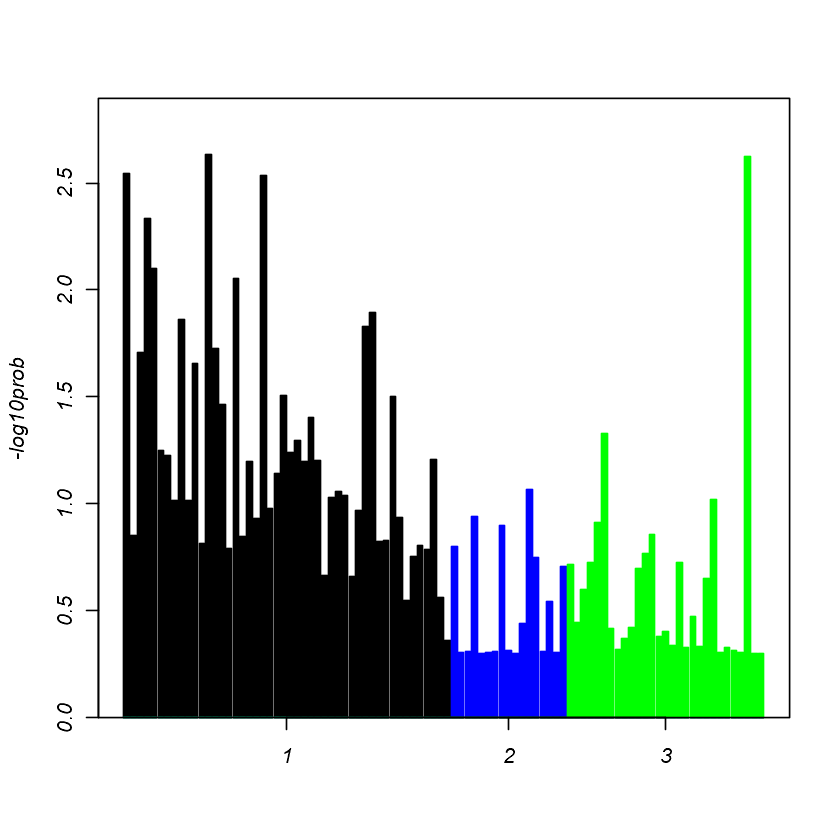

In [19]:
outlg<-round(length(sc@fdata[,1])/100)     # The cell will be considered as an outlier if it has a minimum of 0.5% of the number of filtered genes as outlier genes. 
Outliers<- FindOutliersMB(sc, outminc=5,outlg=outlg,probthr=.5*1e-3,thr=2**-(1:40),outdistquant=1)

#### Removing the defined outlier cells based on Model-Based Clustering

In case the user decided to remove outlier cells, the following cell should be implemented and then the user should start from the beginning (Data Pre-processing). 

In [ ]:
########## Do NOT implement this code if you decided not to remove the outlier cells
names(scc)=NULL
valuesG1ms=valuesG1ms[-scc]
MLSrawWithoutERCC=MLSrawWithoutERCC[-scc]

dim(valuesG1ms)
dim(MLSrawWithoutERCC)

colnames(valuesG1ms)
colnames(MLSrawWithoutERCC)

### 2.2.4. Cellular pseudo-time ordering based on Model-based clusters

In [20]:
sampleNames<-colnames(procdataTSCAN)
sc@MBclusters<-lpsmclustMB

Names<-names(sc@MBclusters$clusterid)

MBorder<-MB_Order(lpsmclustMB,sampleNames,Names)
sc@MBordering<-MBorder

   order orderID
1      1   G2_21
2      2   G2_18
3      3   G2_15
4      4   G2_14
5      5   G2_20
6      6   G1_26
7      7    G2_5
8      8   G2_19
9      9   G2_23
10    10   G2_24
11    11    G2_6
12    12    G2_8
13    13   G2_29
14    14   G2_26
15    15    G2_7
16    16   G2_28
17    17    G2_2
18    18   G1_17
19    19    G2_1
20    20   G2_11
21    21   G2_13
22    22   G2_30
23    23    G1_8
24    24   G2_25
25    25    G1_5
26    26   G1_10
27    27   G1_27
28    28    G2_9
29    29    G1_2
30    30   G2_31
31    31   G2_32
32    32   G1_21
33    33   G1_16
34    34   G1_30
35    35    G1_4
36    36   G1_22
37    37    G1_9
38    38   G1_14
39    39    G1_1
40    40   G1_13
41    41   G1_29
42    42   G1_24
43    43   G2_17
44    44   G1_18
45    45   G2_16
46    46   G1_12
47    47   G1_19
48    48   G1_11
49    49   G1_15
50    50    G2_3
51    51     S_7
52    52    G1_6
53    53   G1_25
54    54    G1_7
55    55   G2_22
56    56    G1_3
57    57   G1_23
58    58    S_

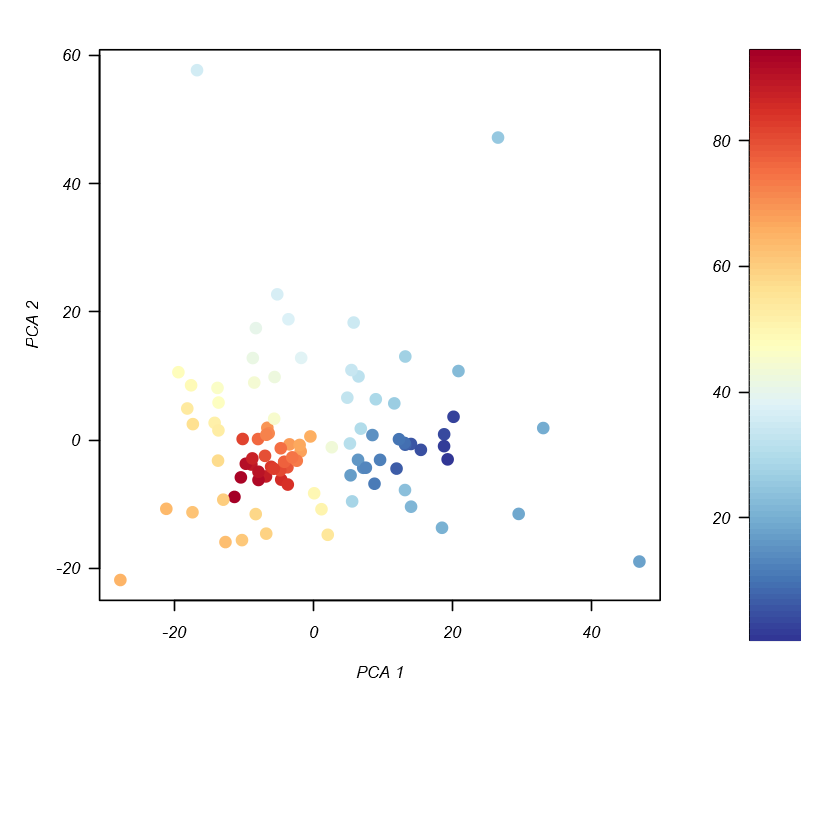

In [21]:
MBordertable<-cbind(lpsmclustMB$pcareduceres,MBorder)
PlotMBorderPCA(MBordertable)

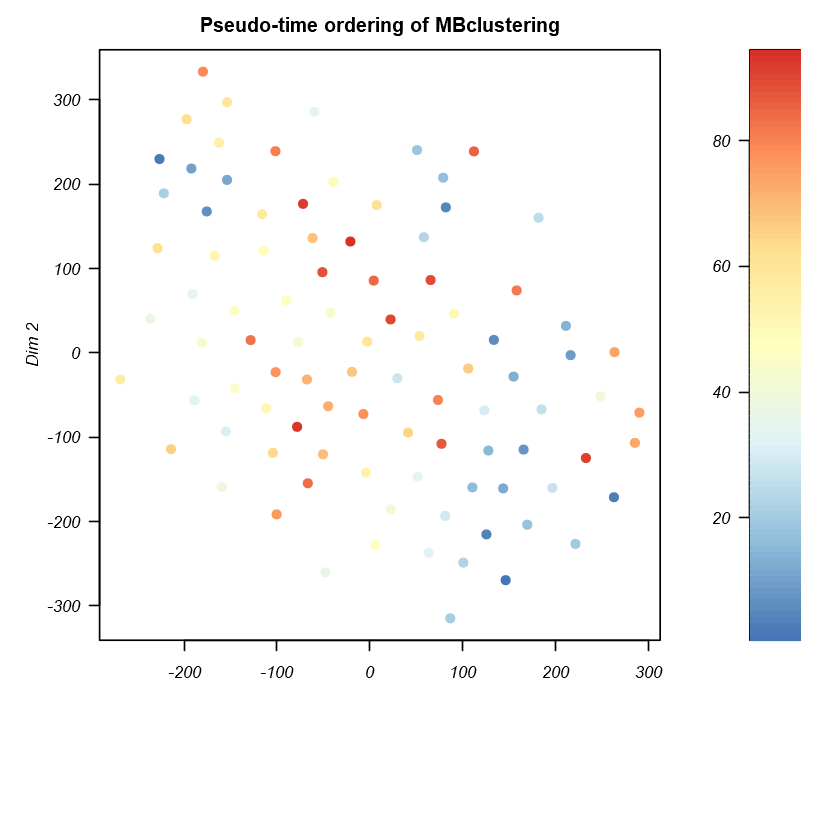

In [22]:
sc@ndata<-rbind(sc@ndata,sc@MBordering)
rownames(sc@ndata)[nrow(sc@ndata)]<-"Pseudo-time ordering of MBclustering"     # in case the user wanted to repeat this step the name: "Pseudo-time ordering of MBclustering" should be change each time.
g<-rownames(sc@ndata)[nrow(sc@ndata)]
plotexptsneMB(sc,g)

#### 2.2.5 Plotting the Model-based clusters in heatmap

[1] 2 1 3

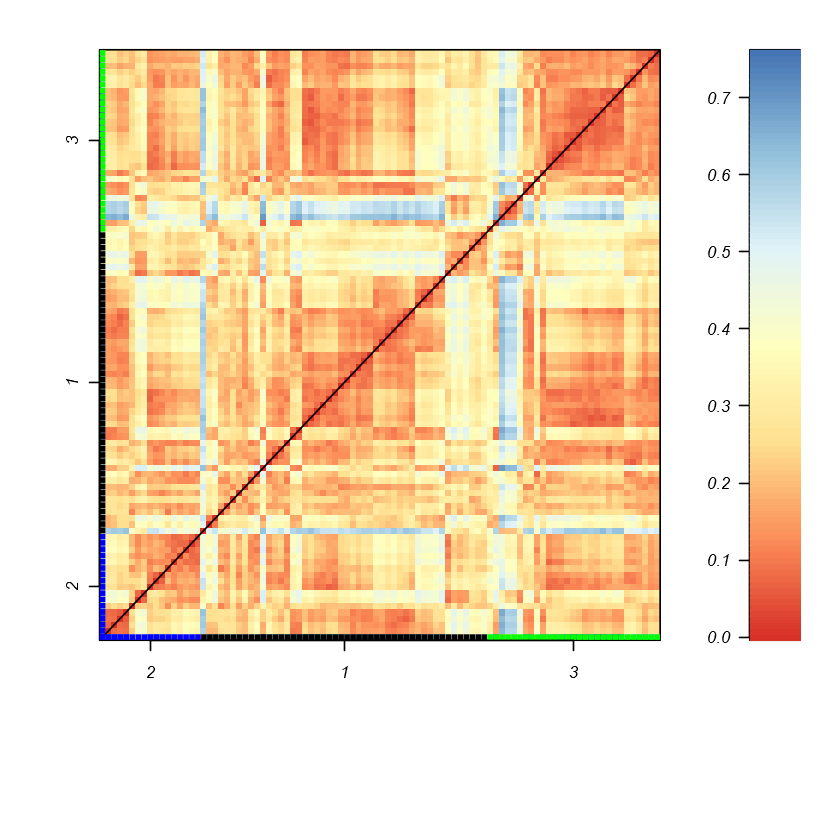

In [23]:
MBclustheatmap(sc)                  # Plotting the model based clusters in heatmap

## 3. Determining differentially expressed genes (DEGs)

Differentially expressed genes between individual clusters are identified using the significance analysis of sequencing data (SAMseq), which is a new function in significance analysis of microarrays (Li and Tibshirani 2011) in the samr package v2.0 (Tibshirani et all., 2015). SAMseq is a non-parametric statistical function dependent on Wilcoxon rank statistic that equalizes the sizes of the library by a resampling method accounting for the various sequencing depths. The analysis is implemented over the pure raw dataset that has the unnormalized expression read counts after excluding the ERCCs. Furthermore, DEGs in each cluster comparing to all the remaining clusters are determined using binomial differential expression, which is based on binomial counting statistics.

![DEGs](DEGS.png)

## 3.1. Determining DEGs between individual clusters

The user can define DEGs between all clusters generated by either K-means or model based clustering by applying the “DEGanalysis” function. Another alternative is to define DEGs between particular clusters generated by either K-means or model based clustering by applying the “DEGanalysisM” function. 

### 3.1.1 Determining DEGs between two particular clusters

[1] 48 29
Estimating sequencing depths...
Resampling to get new data matrices...
perm= 1
perm= 2
perm= 3
perm= 4
perm= 5
perm= 6
perm= 7
perm= 8
perm= 9
perm= 10
perm= 11
perm= 12
perm= 13
perm= 14
perm= 15
perm= 16
perm= 17
perm= 18
perm= 19
perm= 20
perm= 21
perm= 22
perm= 23
perm= 24
perm= 25
perm= 26
perm= 27
perm= 28
perm= 29
perm= 30
perm= 31
perm= 32
perm= 33
perm= 34
perm= 35
perm= 36
perm= 37
perm= 38
perm= 39
perm= 40
perm= 41
perm= 42
perm= 43
perm= 44
perm= 45
perm= 46
perm= 47
perm= 48
perm= 49
perm= 50
perm= 51
perm= 52
perm= 53
perm= 54
perm= 55
perm= 56
perm= 57
perm= 58
perm= 59
perm= 60
perm= 61
perm= 62
perm= 63
perm= 64
perm= 65
perm= 66
perm= 67
perm= 68
perm= 69
perm= 70
perm= 71
perm= 72
perm= 73
perm= 74
perm= 75
perm= 76
perm= 77
perm= 78
perm= 79
perm= 80
perm= 81
perm= 82
perm= 83
perm= 84
perm= 85
perm= 86
perm= 87
perm= 88
perm= 89
perm= 90
perm= 91
perm= 92
perm= 93
perm= 94
perm= 95
perm= 96
perm= 97
perm= 98
perm= 99
perm= 100
Number of thresholds chosen

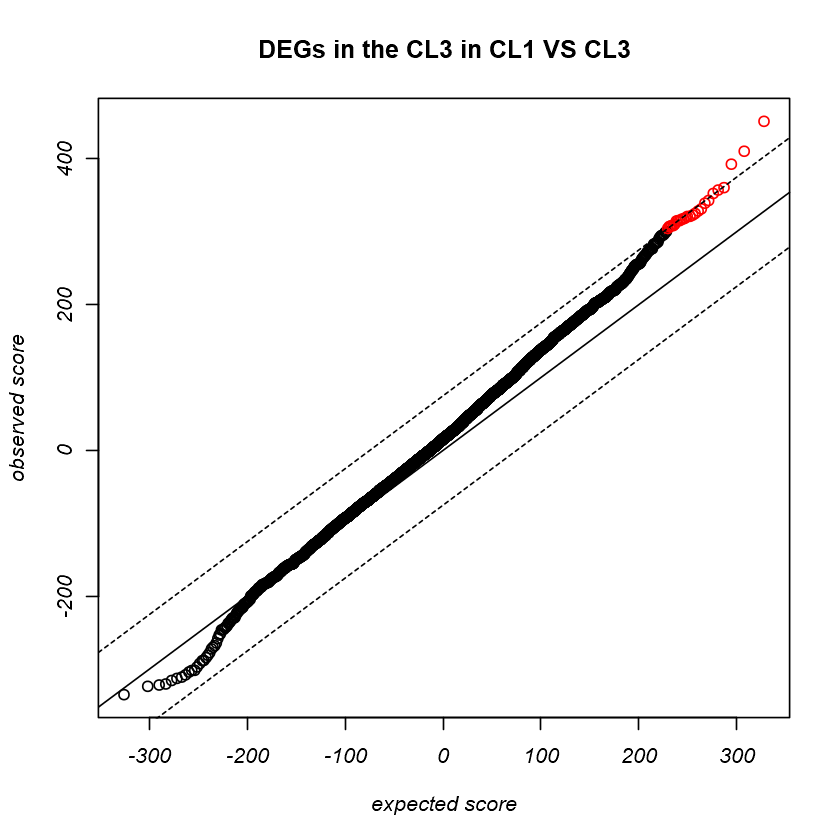

In [17]:
load("LipoNoisFilteredRawDataset.Rdata")
load("LipoExpFilteredrawdata.Rdata")

First<-"CL1"
Second<-"CL3"
#Cluster_ID<-KmeansClusters
Cluster_ID<-MBClusters 
name<-"TT"
fdr=0.05

test<-DEGanalysisM(LipoNoisFilteredRawDataset,Cluster_ID,fdr,name,First,Second)

### 3.1.2 Determining DEGs between all clusters

The dataset is ready for differential expression analysis[1] Cl3 Cl1 Cl2
Levels: Cl1 Cl2 Cl3
Number of comparisons:  6 
Estimating sequencing depths...
Resampling to get new data matrices...
perm= 1
perm= 2
perm= 3
perm= 4
perm= 5
perm= 6
perm= 7
perm= 8
perm= 9
perm= 10
perm= 11
perm= 12
perm= 13
perm= 14
perm= 15
perm= 16
perm= 17
perm= 18
perm= 19
perm= 20
perm= 21
perm= 22
perm= 23
perm= 24
perm= 25
perm= 26
perm= 27
perm= 28
perm= 29
perm= 30
perm= 31
perm= 32
perm= 33
perm= 34
perm= 35
perm= 36
perm= 37
perm= 38
perm= 39
perm= 40
perm= 41
perm= 42
perm= 43
perm= 44
perm= 45
perm= 46
perm= 47
perm= 48
perm= 49
perm= 50
perm= 51
perm= 52
perm= 53
perm= 54
perm= 55
perm= 56
perm= 57
perm= 58
perm= 59
perm= 60
perm= 61
perm= 62
perm= 63
perm= 64
perm= 65
perm= 66
perm= 67
perm= 68
perm= 69
perm= 70
perm= 71
perm= 72
perm= 73
perm= 74
perm= 75
perm= 76
perm= 77
perm= 78
perm= 79
perm= 80
perm= 81
perm= 82
perm= 83
perm= 84
perm= 85
perm= 86
perm= 87
perm= 88
perm= 89
perm= 90
perm= 91

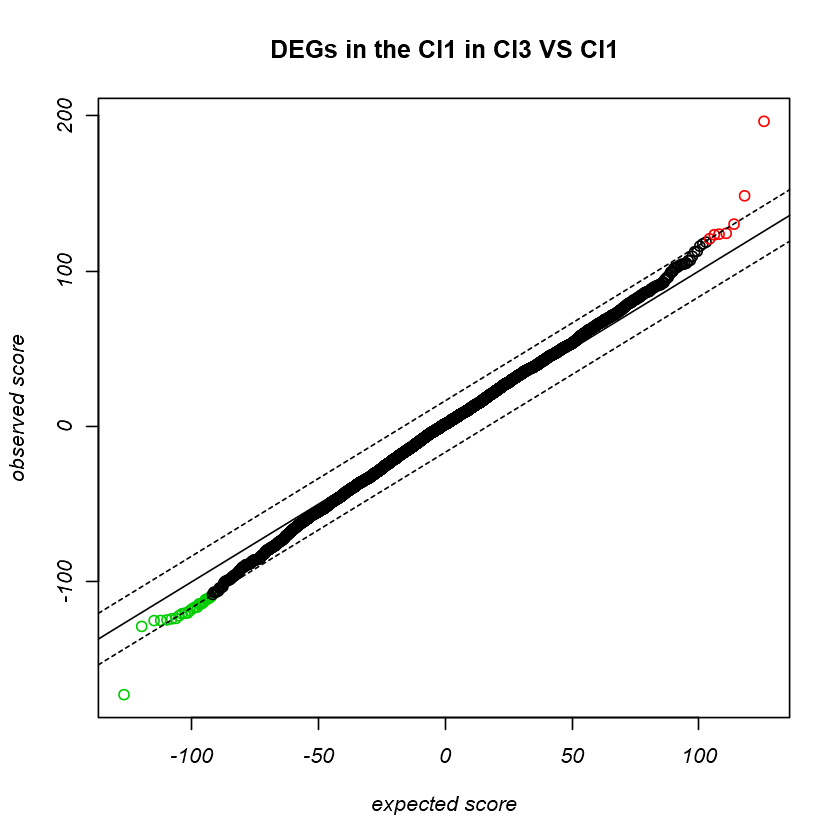

Low-regulated genes in the Cl2 in Cl3 VS Cl2
Up-regulated genes in the Cl2 in Cl3 VS Cl2
Estimating sequencing depths...
Resampling to get new data matrices...
perm= 1
perm= 2
perm= 3
perm= 4
perm= 5
perm= 6
perm= 7
perm= 8
perm= 9
perm= 10
perm= 11
perm= 12
perm= 13
perm= 14
perm= 15
perm= 16
perm= 17
perm= 18
perm= 19
perm= 20
perm= 21
perm= 22
perm= 23
perm= 24
perm= 25
perm= 26
perm= 27
perm= 28
perm= 29
perm= 30
perm= 31
perm= 32
perm= 33
perm= 34
perm= 35
perm= 36
perm= 37
perm= 38
perm= 39
perm= 40
perm= 41
perm= 42
perm= 43
perm= 44
perm= 45
perm= 46
perm= 47
perm= 48
perm= 49
perm= 50
perm= 51
perm= 52
perm= 53
perm= 54
perm= 55
perm= 56
perm= 57
perm= 58
perm= 59
perm= 60
perm= 61
perm= 62
perm= 63
perm= 64
perm= 65
perm= 66
perm= 67
perm= 68
perm= 69
perm= 70
perm= 71
perm= 72
perm= 73
perm= 74
perm= 75
perm= 76
perm= 77
perm= 78
perm= 79
perm= 80
perm= 81
perm= 82
perm= 83
perm= 84
perm= 85
perm= 86
perm= 87
perm= 88
perm= 89
perm= 90
perm= 91
perm= 92
perm= 93
perm= 94
per

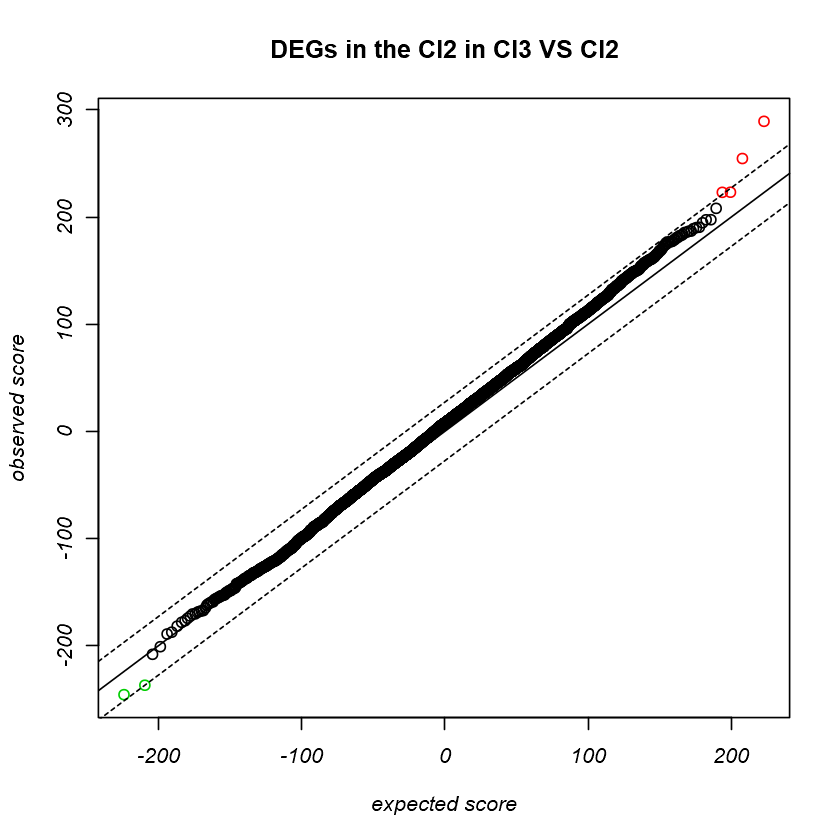

Low-regulated genes in the Cl2 in Cl1 VS Cl2
Up-regulated genes in the Cl2 in Cl1 VS Cl2
The results of DEGs are saved in your directory 
  Comparisons Target cluster Up-regulated genes
1  Cl3 VS Cl1            Cl1                  7
2  Cl3 VS Cl2            Cl2                  4
3  Cl1 VS Cl2            Cl2                  4
4  Cl3 VS Cl1            Cl3                  7
5  Cl3 VS Cl2            Cl3                  4
6  Cl1 VS Cl2            Cl1                  4
                             File name Low-regulated genes
1  Up-regulated-KM0.2Cl1inCl3VSCl1.csv                  24
2  Up-regulated-KM0.2Cl2inCl3VSCl2.csv                   2
3  Up-regulated-KM0.2Cl2inCl1VSCl2.csv                   1
4 Low-regulated-KM0.2Cl3inCl3VSCl1.csv                  24
5 Low-regulated-KM0.2Cl3inCl3VSCl2.csv                   2
6 Low-regulated-KM0.2Cl1inCl1VSCl2.csv                   1
                             File name
1 Low-regulated-KM0.2Cl1inCl3VSCl1.csv
2 Low-regulated-KM0.2Cl2inCl3VSCl2.

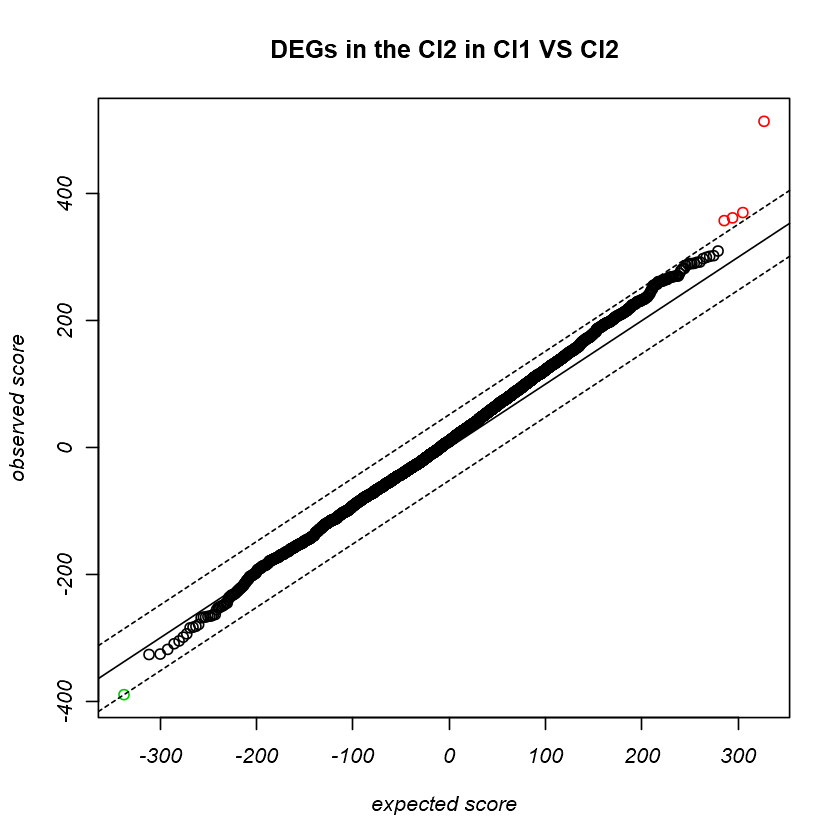

In [24]:
load("LipoNoisFilteredRawDataset.Rdata")
load("LipoExpFilteredrawdata.Rdata")

Cluster_ID<-KmeansClusters
#Cluster_ID<-MBClusters 
fdr=0.2
name<-"KM0.2"
sigDEGs<-DEGanalysis(LipoNoisFilteredRawDataset,Cluster_ID,K,fdr,name)

In [25]:
sigDEGs[[2]]  #### To show the result table

Comparisons,Target cluster,Up-regulated genes,File name,Low-regulated genes,File name
Cl3 VS Cl1,Cl1,7,Up-regulated-KM0.2Cl1inCl3VSCl1.csv,24,Low-regulated-KM0.2Cl1inCl3VSCl1.csv
Cl3 VS Cl2,Cl2,4,Up-regulated-KM0.2Cl2inCl3VSCl2.csv,2,Low-regulated-KM0.2Cl2inCl3VSCl2.csv
Cl1 VS Cl2,Cl2,4,Up-regulated-KM0.2Cl2inCl1VSCl2.csv,1,Low-regulated-KM0.2Cl2inCl1VSCl2.csv
Cl3 VS Cl1,Cl3,7,Low-regulated-KM0.2Cl3inCl3VSCl1.csv,24,Up-regulated-KM0.2Cl3inCl3VSCl1.csv
Cl3 VS Cl2,Cl3,4,Low-regulated-KM0.2Cl3inCl3VSCl2.csv,2,Up-regulated-KM0.2Cl3inCl3VSCl2.csv
Cl1 VS Cl2,Cl1,4,Low-regulated-KM0.2Cl1inCl1VSCl2.csv,1,Up-regulated-KM0.2Cl1inCl1VSCl2.csv


### Plotting the DEGs

Volcano plots are used to readily show the DEGs by plotting significance versus fold-change on the y and x axes, respectively.

[1] 7 9

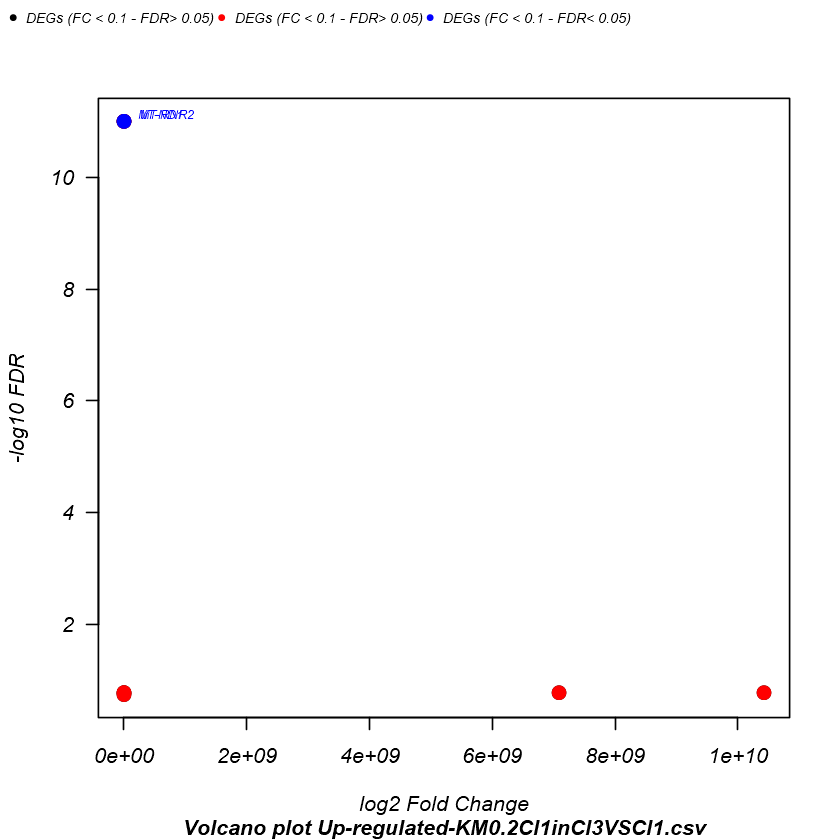

In [28]:
DEGs<-sigDEGs[[2]][1,4]     #The user should select from "sigDEGs[[2]]" the row and column of the target file
#DEGs<-cdiff[[2]][3,6]
U<-read.csv(file=paste0(DEGs),head=TRUE,sep=",")
dim(U)
fc=0.1
Value=0.05
Vplot<-VolcanoPlot(U,Value,DEGs,fc,adj=T)   #### In case the output of this function is an error "Error in plot.window(...): need finite 'ylim' values", the adj should be set to TRUE 

## 4. Identifying biomarkers (decision trees and networking analysis) 

There are several methods to identify biomarkers, among them are decision trees and hub detection through networking analysis. The outcome of STRING analysis is stored in tab separated values (TSV) files. These TSV files served as an input to check both the connectivity degree and the betweenness centrality, which reflects the communication flow in the defined PPI networks 

![Biomarkers](IdentBiomarkers.png)

Decision trees are one of the most efficient classification techniques in biomarkers discovery.  Here we use it to predict the sub-population of a target cell based on transcriptomic data. Two types of decision trees can be performed: classification and regression trees (CART) and J48. The decision tree analysis is implemented over a training dataset, which consisted of the DEGs obtained by either SAMseq or the binomial differential expression. The performance of the generated trees can be evaluated for error estimation by ten-fold cross validation assessment using the "J48DTeval" and "RpartEVAL" functions.
The decision tree analysis requires the dataset to be class vectored by applying the “ClassVectoringDT” function.

In [29]:
Cluster_ID<-KmeansClusters
#Cluster_ID<-MBClusters 
First<-"CL1"
Second<-"CL3"

sigDEG<-sigDEGs[[1]] 
#sigDEG<-cdiff[[1]]

DATAforDT<-ClassVectoringDT(MLSrawWithoutERCC,Cluster_ID,K,First,Second,sigDEG)

The DEGs filtered normalized dataset contains: 
 Genes: 37 
 cells: 42

### 4.1. J48 Decision Tree

J48 pruned tree
------------------

MT-RNR2 <= 41518.323682: CL3 (14.0)
MT-RNR2 > 41518.323682: CL1 (28.0/1.0)

Number of Leaves  : 	2

Size of the tree : 	3




=== Summary ===

Correctly Classified Instances          41               97.619  %
Incorrectly Classified Instances         1                2.381  %
Kappa statistic                          0.9474
Mean absolute error                      0.0459
Root mean squared error                  0.1515
Relative absolute error                  9.9598 %
Root relative squared error             31.6199 %
Total Number of Instances               42     

=== Confusion Matrix ===

  a  b   <-- classified as
 27  0 |  a = CL1
  1 14 |  b = CL3

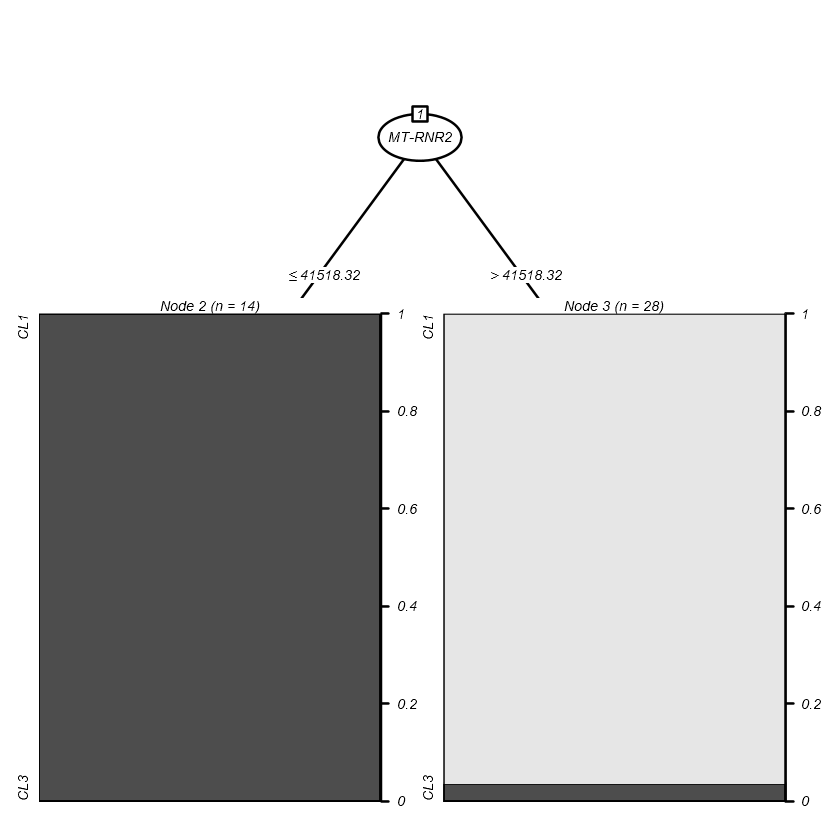

In [30]:
j48dt<-J48DT(DATAforDT)
summary(j48dt) 

#### 4.1.1. Evaluating the performance of the J48 Decision Tree

In [31]:
j48dt<-J48DTeval(DATAforDT,num.folds=10,First,Second)

Fold 1 of 10 
Fold 2 of 10 
Fold 3 of 10 
Fold 4 of 10 
Fold 5 of 10 
Fold 6 of 10 
Fold 7 of 10 
Fold 8 of 10 
Fold 9 of 10 
Fold 10 of 10 
TP FN FP TN 
27  0  2 13 
             CL1 CL3
PredictedCL1  27   2
PredictedCL3   0  13
J48 SN: 1
J48 SP: 0.8666667
J48 ACC: 0.952381
J48 MCC: 0.8982742


### 4.2. RPART Decision Tree

n= 42 

node), split, n, loss, yval, (yprob)
      * denotes terminal node

1) root 42 15 CL1 (0.64285714 0.35714286)  
  2) MT-RNR2>=41999.57 28  1 CL1 (0.96428571 0.03571429)  
    4) CORO1C>=95.54071 27  0 CL1 (1.00000000 0.00000000) *
    5) CORO1C< 95.54071 1  0 CL3 (0.00000000 1.00000000) *
  3) MT-RNR2< 41999.57 14  0 CL3 (0.00000000 1.00000000) *


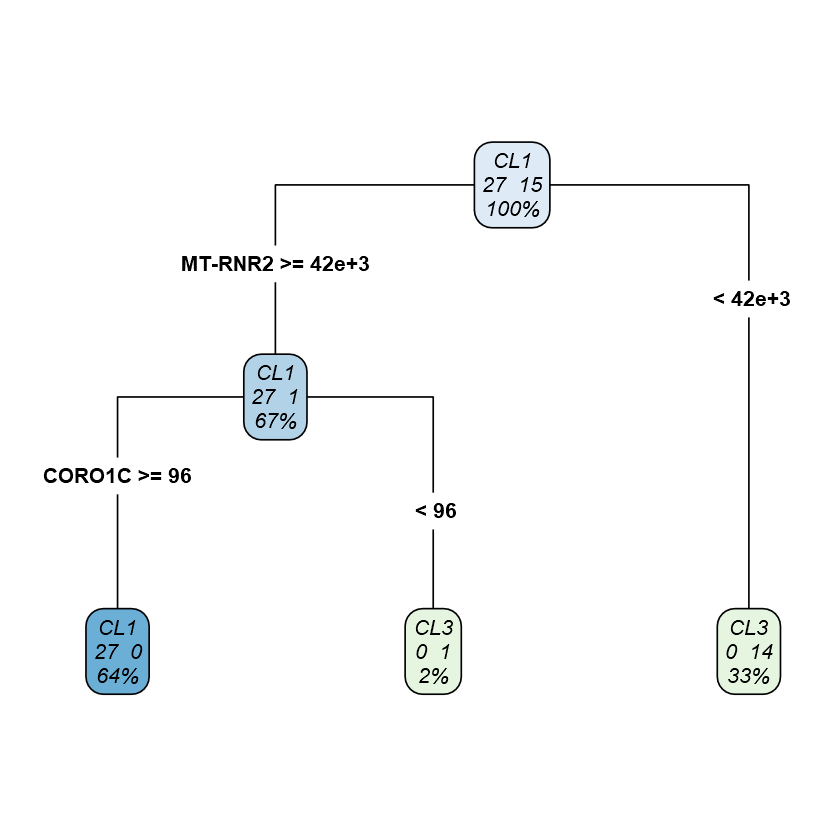

In [32]:
rpartDT<-RpartDT(DATAforDT)

#### 4.2.1. Evaluating the performance of the RPART Decision Tree

In [33]:
rpartEVAL<-RpartEVAL(DATAforDT,num.folds=10,First,Second)

Fold 1 of 10 
Fold 2 of 10 
Fold 3 of 10 
Fold 4 of 10 
Fold 5 of 10 
Fold 6 of 10 
Fold 7 of 10 
Fold 8 of 10 
Fold 9 of 10 
Fold 10 of 10 
TP FN FP TN 
25  2  1 14 
             CL1 CL3
PredictedCL1  25   1
PredictedCL3   2  14
Rpart SN: 0.9259259
Rpart SP: 0.9333333
Rpart ACC: 0.9285714
Rpart MCC: 0.8478228


### 4.3. Networking Analysis

To define protein-protein interactions (PPI) over a list of genes, STRING-api is used. The outcome of STRING analysis was stored in tab separated values (TSV) files. These TSV files served as an input to check both the connectivity degree and the betweenness centrality, which reflects the communication flow in the defined PPI networks.

In [36]:
DEGs<-sigDEGs[[2]][1,6]     #The user should select from "sigDEGs[[2]]" the row and column of the target file
#DEGs<-cdiff[[2]][3,4]
data<-read.csv(file=paste0(DEGs),head=TRUE,sep=",")
data<-data[,3]

FileName=paste0(DEGs)

ppi<-PPI(data,FileName)
ppi

networking<-NetAnalysis(ppi)
networking                            ##### In case the Examine response components = 200 and an error "linkmat[i, ]" appeared, that means there are no PPI.


Examine response components = 200 	 200 means successful 


No encoding supplied: defaulting to UTF-8.


stringId_A,stringId_B,preferredName_A,preferredName_B,ncbiTaxonId,score,nscore,fscore,pscore,ascore,escore,dscore,tscore
ENSP00000317334,ENSP00000012443,TCP1,PPP5C,9606,0.921,0,0,0,0.141,0.143,0.9,0.063000
ENSP00000318697,ENSP00000317334,TUBB6,TCP1,9606,0.915,0,0,0,0.057,0.162,0.9,0.058000
ENSP00000349960,ENSP00000296755,ACTB,MAP1B,9606,0.500,0,0,0,0.051,0.379,0.0,0.219000
ENSP00000349960,ENSP00000317334,ACTB,TCP1,9606,0.964,0,0,0,0.063,0.345,0.9,0.494000
ENSP00000349960,ENSP00000318697,ACTB,TUBB6,9606,0.933,0,0,0,0.090,0.095,0.9,0.289000
ENSP00000349960,ENSP00000344456,ACTB,CTNNB1,9606,0.677,0,0,0,0.064,0.321,0.0,0.533000
ENSP00000351022,ENSP00000349960,TPM1,ACTB,9606,0.791,0,0,0,0.111,0.599,0.0,0.462000
ENSP00000359225,ENSP00000349960,CNN3,ACTB,9606,0.403,0,0,0,0.063,0.158,0.0,0.304000
ENSP00000364721,ENSP00000296755,MAPRE1,MAP1B,9606,0.420,0,0,0,0.063,0.299,0.0,0.189000
ENSP00000364721,ENSP00000318697,MAPRE1,TUBB6,9606,0.466,0,0,0,0.082,0.366,0.0,0.156000


Number of nodes:  13 
Number of links:  19 
Link Density:  1.461538 
The connectance of the graph:  0.1217949 
Mean Distences 1.688889 
Average Path Length 1.688889 
 


names,degree,betweenness
TCP1,4,8.0
TUBB6,4,2.0
ACTB,9,20.5
TPM1,2,0.0
CNN3,1,0.0
MAPRE1,3,0.5
TUBB2A,4,0.0
ACTN1,4,0.0
PUM1,1,0.0
PPP5C,1,0.0


Examine response components = 200 	 200 means successful 


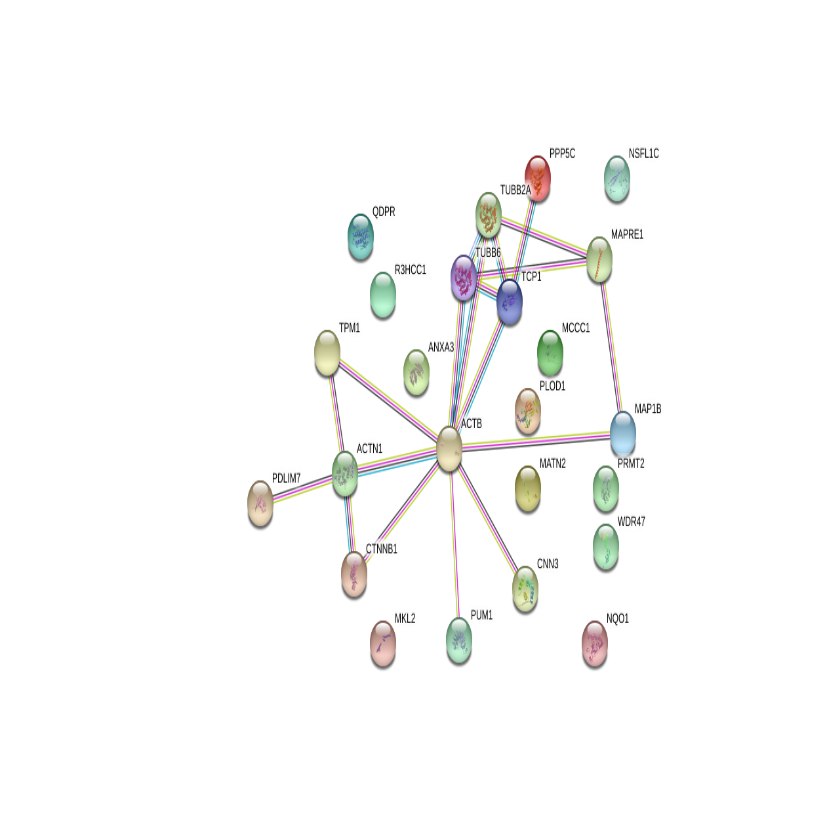

In [37]:
#data<-rownames(DATAforDT)  #####3 generating a network of all the DEGs
#length(data)
FileName="Up.DownDEG" 

DEGs<-sigDEGs[[2]][1,6]     #The user should select from "sigDEGs[[2]]" the row and column of the target file
data<-read.csv(file=paste0(DEGs),head=TRUE,sep=",")
data<-data[,3]

network<-Networking(data,FileName)